# Imports

In [1]:
import os

from torch.utils.data import DataLoader

from src.utils import (
    ForestDataset,
    Preprocessor,
    get_device,
    load,
    plot_image_and_prediction,
    predict_image,
    predict_patch,
    plot_image_channels,
)

# Global parameters

In [2]:
patch_size = 256
img_dir = "data/images"
model_dir = "models"
patch_dir = "data/patches"
gedi_dir = "data/gedi"
random_state = 42
batch_size = 12
num_workers = os.cpu_count()
bins = list(range(0, 55, 5))
device = get_device()

Using mps device


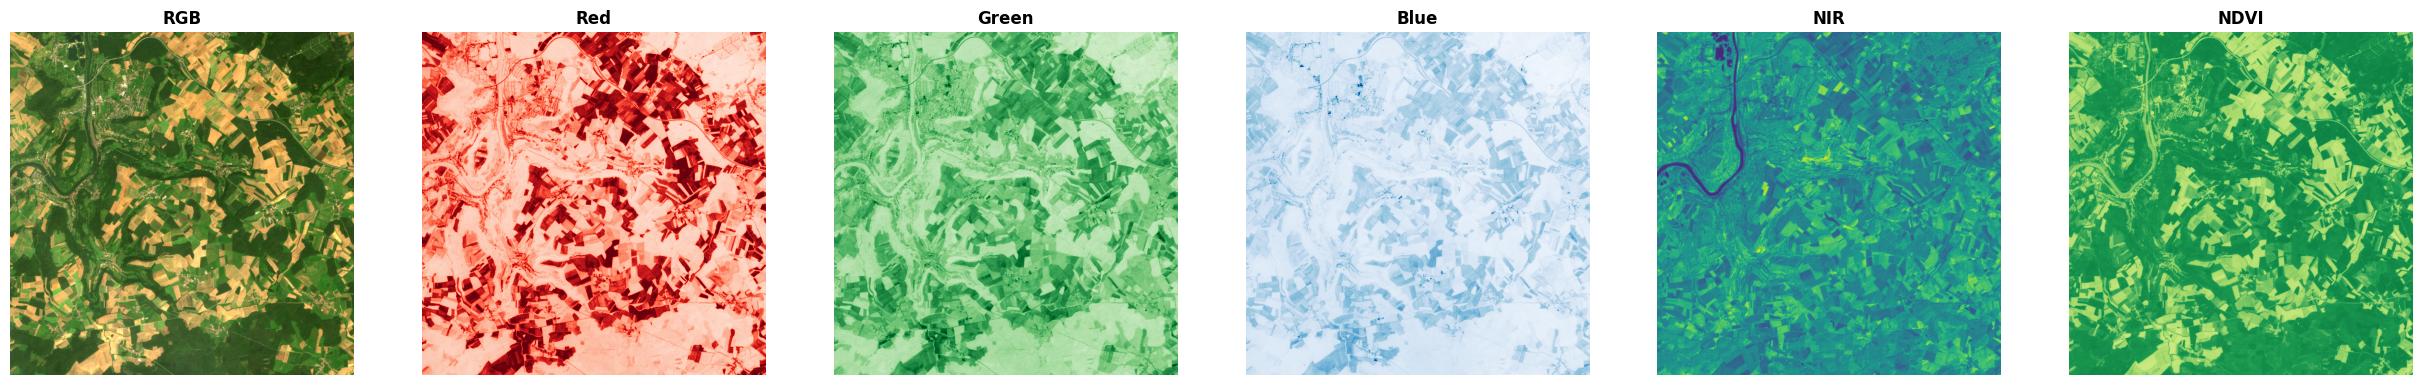

In [3]:
plot_image_channels(f"{img_dir}/L15-1060E-1348N.tif")

# Create dataloaders

In [5]:
# Create preprocessor
preprocessor = Preprocessor(img_dir, patch_dir, gedi_dir, patch_size)

# Run preprocessor
preprocessor.run()

# Get labels
labels = preprocessor.gedi.rh98

# Get patches
patches = preprocessor.patches

INFO:root:Starting preprocessing...
INFO:root:Directories validated.
INFO:root:Images loaded.
INFO:root:Number of images: 50
INFO:root:GEDI data loaded.
INFO:root:Loaded existing patch info file. Skipping image processing.
INFO:root:Number of patches: 9234
INFO:root:Number of labels: 629074


In [ ]:
# Plot histogram of labels
labels.hist(bins=bins)

# Create datasets & dataloader

In [6]:
# Create dataset
data = ForestDataset(patches, f"{patch_dir}/{patch_size}")
# Create dataloader
loader = DataLoader(data, batch_size, False, num_workers=num_workers)

# Create & Train model

In [7]:
# Load model
filename = "unet.pt"

model = load(os.path.join(model_dir, filename), device)

# Visualise results

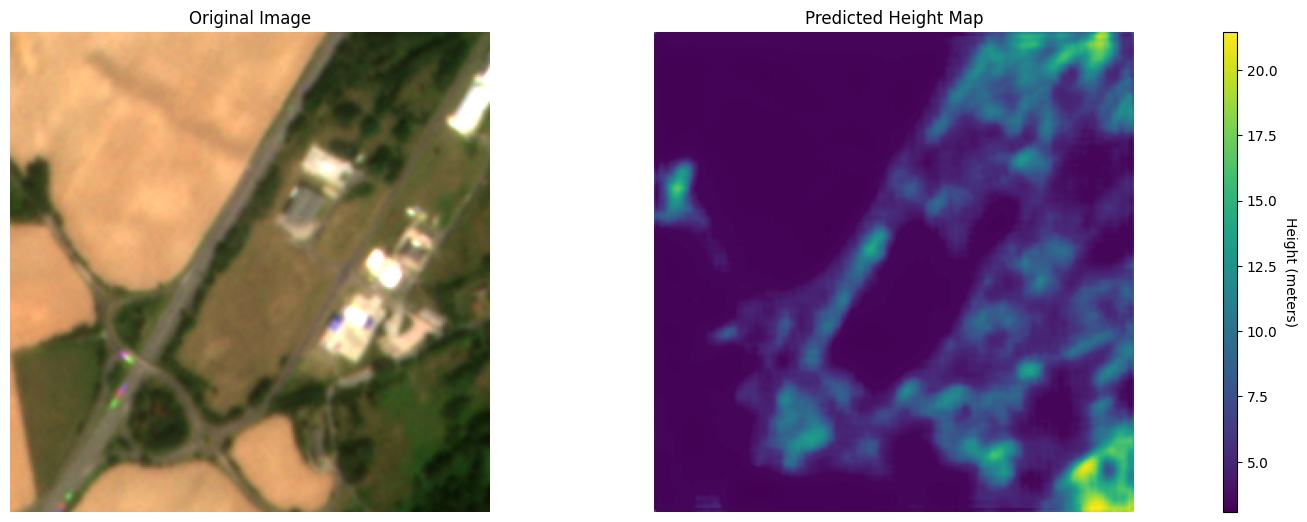

In [15]:
idx = 42
patch = data[idx]
img, pred = predict_patch(model, patch, device)
plot_image_and_prediction(img, pred, 3)

In [9]:
image, prediction = predict_image(
    model, device, f"{img_dir}/L15-1059E-1348N.tif", patch_size
)

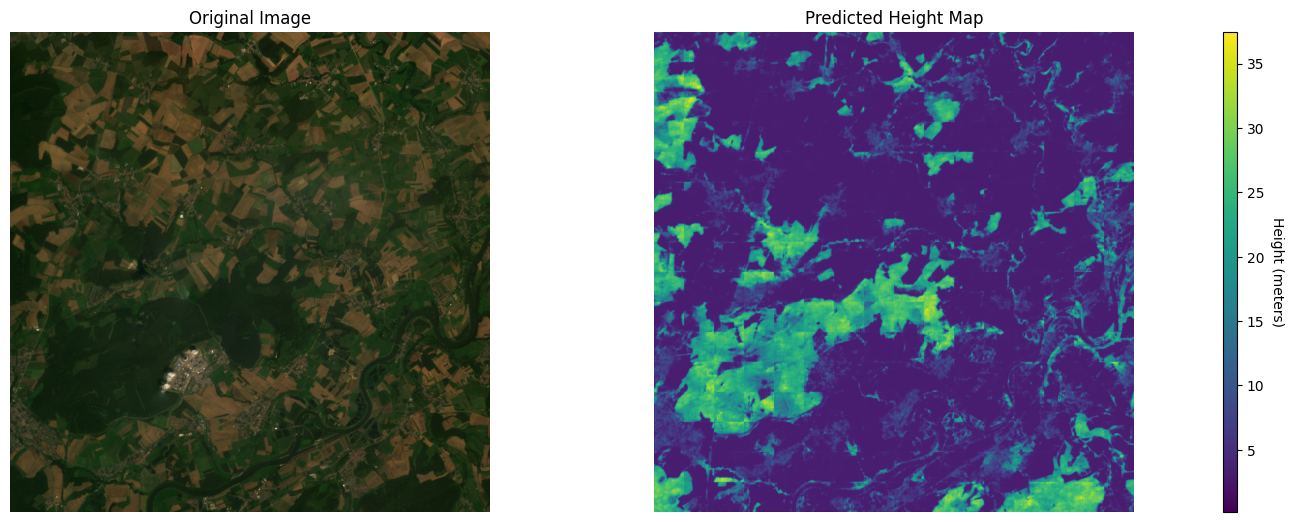

In [10]:
plot_image_and_prediction(image, prediction, 3)